# 1. Overview

This competition, "Pump it Up: Data Mining the Water Table," hosted on DrivenData, challenges participants to predict the functional status of water pumps across Tanzania using a provided dataset. The contest spans from 2024 and aims to enhance access to clean, potable water by identifying malfunctioning water pumps. Participants are supplied with extensive data on various characteristics of the water points, from construction year to water quality. The primary goal is to classify each water point into one of three categories: functional, functional needs repair, and non-functional. This analysis could guide strategic decisions for improving water access and infrastructure investments in developing regions.

# 2. Business Understanding

The core objective of the "Pump it Up: Data Mining the Water Table" competition is to enable the identification of water pumps in Tanzania that are functional, require repairs, or are non-functional. The insights derived from this analysis will directly influence decisions regarding maintenance, investments, and resource allocation in the water infrastructure sector. Stakeholders, including government agencies and NGOs, will use these findings to prioritize and streamline efforts towards ensuring reliable water access. By effectively categorizing water points, the project aims to enhance operational efficiencies and reduce downtime due to pump failures. The ultimate goal is to support sustainable water management practices that can significantly impact public health and economic development in Tanzania.

Primary stakeholders for this project are the Tanzanian government and international development organizations focused on improving water access in the region.

# 3. Data Understanding

## 3.1 Data Description

Drawing from a comprehensive dataset provided by the "Pump it Up: Data Mining the Water Table" competition on DrivenData, our analysis is centered around extensive information regarding water points across Tanzania. This dataset includes:

- Geographic data such as location coordinates, altitude, and administrative divisions (region, district, and ward).
- Water point specifics such as the type, construction year, funding organization, and managing entity.
- Operational data including the water source, extraction type, water quality, and current functional status of each water pump.

Our investigation targets three key objectives: identifying patterns of pump functionality, understanding factors leading to pump failures or repairs, and assessing the impacts of management practices on pump operability. By analyzing these elements, we aim to derive actionable insights that can guide infrastructural improvements and strategic investments in water resource management. The outcome of this analysis will inform decision-making processes for stakeholders involved in Tanzanian water supply, optimizing interventions for enhanced water accessibility and reliability. This focused approach empowers our stakeholders to efficiently address the most critical needs, leveraging data-driven strategies to improve public health and community resilience.

## 3.2 Import Necessary Libraries

In [1]:
#pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re  # Import regular expressions library

from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

import pickle
import warnings
warnings.filterwarnings("ignore")

## 3.3 Define global variables

In [3]:
INPUT_PATH_Submission_Format = "../Data/SubmissionFormat.csv"
INPUT_PATH_Test_set_values = "../Data/Test_set_values.csv"
INPUT_PATH_Training_set_labels = "../Data/Training_set_labels.csv"
INPUT_PATH_Training_set_values = "../Data/Training_set_values.csv"

## 3.4 Functions

In [4]:
from project_functions import *

# 4. DATA UNDERSTANDING

## 4.1 Exploratory Analysis

#### 4.1.1.1 Looking at the train and labels dataset

In [5]:
df_train = pd.read_csv(INPUT_PATH_Training_set_values)
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
df_train.shape

(59400, 40)

In [7]:
df_labels = pd.read_csv(INPUT_PATH_Training_set_labels)
df_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df_labels.shape

(59400, 2)

#### 4.1.1.2 Merge both datasets

In [9]:
df_train_merge = pd.merge(df_train, df_labels)
df_train_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [10]:
df_train_merge.shape

(59400, 41)

As we can see above the merge has been done correctly because the number of rows is intact and the training set values has just one more column containing the training set labels

#### 4.1.3 - Data Types

In [11]:
# Let's start by having a look at the type of each column
df_train_merge.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

**Column 'funder'**

In [12]:
# Handling NaN values with a filler string like 'Unknown'
df_train_merge['funder'] = df_train_merge['funder'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'funder' column
df_train_merge['funder_type'] = df_train_merge['funder'].apply(categorize_funder)

# Check the categorized data
print(df_train_merge['funder_type'].value_counts())

Individual/Other           39410
Government                 10017
International Aid           8468
Religious Organizations     1299
NGO                          146
Private Companies             60
Name: funder_type, dtype: int64


For the time being, we will advance with this categorization and decide later if we want to further investigate the Individual/Other category if necessary

**Column 'installer'**

In [13]:
# Handling NaN values with a filler string like 'Unknown'
df_train_merge['installer'] = df_train_merge['installer'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'installer' column
df_train_merge['installer_type'] = df_train_merge['installer'].apply(categorize_installer)

# Now you can check your categorized data
print(df_train_merge['installer_type'].value_counts())


Other              34031
DWE                18121
Government          3753
Community           2338
Institutional        701
NGO                  327
Private Company      129
Name: installer_type, dtype: int64


For the time being, we will advance with this categorization and decide later if we want to further investigate the Individual/Other category if necessary

**Column 'scheme_management'**

We will categorize, based on this classification:

- Governmental Entities: Combine 'VWC' (Village Water Committee), 'Water authority', and 'Parastatal' into a single 'Government' category. These typically represent different layers or types of governmental involvement.

- Community Managed: Merge 'WUG' (Water User Group) and 'WUA' (Water User Association) into 'Community'. These are likely community-based management structures.

- Commercial Entities: Group 'Company' and 'Private operator' into 'Private Sector'. These likely represent privately managed schemes.

- Institutional Boards: Keep 'Water Board' as is if they represent formal institutional water management boards that don't fit into other categories.

- Other and Miscellaneous: Combine 'SWC', 'Trust', 'None', and 'Other' into 'Other'. These categories might represent less common or unclear management structures.

In [14]:
# Apply the grouping function to the 'scheme_management' column
df_train_merge['scheme_management_grouped'] = df_train_merge['scheme_management'].apply(group_scheme_management)

# Check the new value counts to see the grouped data
print(df_train_merge['scheme_management_grouped'].value_counts(normalize=True))


Government        0.700774
Community         0.136178
Other             0.081027
Water Board       0.046263
Private Sector    0.035758
Name: scheme_management_grouped, dtype: float64


**Column 'scheme_name'**

Given that there is almost 50% of unknown data, and the widespread of data, we will eliminate this column directly

In [15]:
# Start creating our drop list
drop_column_list = ['scheme_name']

**Column 'num_private'**

Given that num_private has no description and given that it has many values, we are going to add this to the drop list column

In [16]:
drop_column_list.append('num_private')
drop_column_list

['scheme_name', 'num_private']

**Column 'wpt_name '**

No further information is added with this wpt_name column as it is the name of the waterpoint. We will add this to the drop_list

In [17]:
drop_column_list.append('wpt_name')
drop_column_list

['scheme_name', 'num_private', 'wpt_name']

**Column 'construction_year'**

Converting 'construction_year' to object

In [18]:
df_train_merge['construction_year'] = df_train_merge['construction_year'].astype('object')
print(df_train_merge['construction_year'].dtype)

object


**Columns: 'subvillage' and 'region'**

Having subvillage wouldn't give more insights to the model. There are more than 19k registrations of subvillages. Column 'region' alredy is a categorization of column 'subvillage' and so, we decide to add this column to the drop_list

In [19]:
drop_column_list.append('subvillage')
drop_column_list

['scheme_name', 'num_private', 'wpt_name', 'subvillage']

**Columns: 'lga', 'ward'**

As we already have column 'region' and columns: 'lga' and 'ward' are geographic locations. To avoid multiollinearity we will add 'lga'and 'ward' to the drop_list

In [20]:
drop_column_list.append('lga')
drop_column_list.append('ward')

drop_column_list

['scheme_name', 'num_private', 'wpt_name', 'subvillage', 'lga', 'ward']

**Columns: 'recorded_by'**

In [21]:
# Drop recorded_by column since it's constant and should be ignored
drop_column_list.append('recorded_by')
drop_column_list

['scheme_name',
 'num_private',
 'wpt_name',
 'subvillage',
 'lga',
 'ward',
 'recorded_by']

**Dropping the columns list**

In [22]:
# Carry out the dropping
df_train_merge = df_train_merge.drop(drop_column_list, axis=1)

In [23]:
df_train_merge.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

##### 4.1.1.3.2 - Transforming column types

**Column 'public_meeting'**

In [24]:
print(df_train_merge['public_meeting'].dtype)

object


**Column 'permit'**

In [25]:
print(df_train_merge['permit'].dtype)

object


##### 4.1.1.3.3 - Cleaning the dataset

In [26]:
# Apply the cleaning function to each object-type column in the DataFrame
for col in df_train_merge.select_dtypes(include='object').columns:
    df_train_merge[col] = df_train_merge[col].apply(clean_text)

# Display the cleaned DataFrame
df_train_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,funder_type,installer_type,scheme_management_grouped
0,69572,6000.0,,roman,1390,roman,34.938093,-9.856322,lake nyasa,iringa,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,individualother,other,government
1,8776,0.0,,grumeti,1399,grumeti,34.698766,-2.147466,lake victoria,mara,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,individualother,other,other
2,34310,25.0,,lottery club,686,world vision,37.460664,-3.821329,pangani,manyara,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,individualother,other,government
3,67743,0.0,,unicef,263,unicef,38.486161,-11.155298,ruvuma southern coast,mtwara,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,international aid,ngo,government
4,19728,0.0,,action in a,0,artisan,31.130847,-1.825359,lake victoria,kagera,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,individualother,other,other


### 4.1.2 Descriptive Analysis

For a detailed description of the findings from the univariate and multivariate analysis of the data, please refer to the data understanding notebook available at this link: [Go to Notebook 00_data_understanding.ipynb](00_data_understanding.ipynb) .

This notebook provides comprehensive insights into the individual variables' distributions (univariate analysis) and their relationships with each other (multivariate analysis), offering a deeper understanding of the dataset's characteristics and patterns. 

**Numerical columns**

In [27]:
numeric_columns = df_train_merge.select_dtypes(include=[np.number])
numeric_columns = numeric_columns.drop(['id','longitude','latitude','region_code','district_code','construction_year'], axis=1)
numeric_columns

,amount_tsh,gps_height,population
0,6000.0,1390,109
1,0.0,1399,280
2,25.0,686,250
3,0.0,263,58
4,0.0,0,0
...,...,...,...
59395,10.0,1210,125
59396,4700.0,1212,56
59397,0.0,0,0
59398,0.0,0,0


**Categorical columns**

In [28]:
categorical_columns = df_train_merge.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['date_recorded', 'funder', 'installer', 'basin', 'region',
       'public_meeting', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

In [29]:
categorical_columns = categorical_columns.drop(['funder','installer','scheme_management','status_group'])

In [30]:
categorical_columns

Index(['date_recorded', 'basin', 'region', 'public_meeting', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

In [31]:
drop_categorical_columns = ['extraction_type_group', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'source_class','waterpoint_type_group']

In [32]:
# Drop the list of columns from df_train_merge
df_train_merge = df_train_merge.drop(drop_categorical_columns, axis=1)

In [33]:
categorical_columns = categorical_columns.drop(drop_categorical_columns)
categorical_columns

Index(['date_recorded', 'basin', 'region', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'waterpoint_type',
       'funder_type', 'installer_type', 'scheme_management_grouped'],
      dtype='object')

### 4.1.2.3 Filtering the final dataset

In [34]:
# Let's join together numeric_columns and categorical_columns into a list that we will pass as an argument to the multavaried
# analysis function
combined_columns = numeric_columns.columns.tolist() + categorical_columns.tolist()
combined_columns.append('status_group')
combined_columns

['amount_tsh',
 'gps_height',
 'population',
 'date_recorded',
 'basin',
 'region',
 'public_meeting',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_type',
 'waterpoint_type',
 'funder_type',
 'installer_type',
 'scheme_management_grouped',
 'status_group']

In [35]:
df=df_train_merge[combined_columns]

# 5. DATA PREPROCESSING
# Overview

Based on the descriptive and exploratory analysis conducted in the previous section, and the data preprocessing detailed in the notebook [Go to Notebook 01_data_preprocessing.ipynb](01_data_preprocessing.ipynb), this section will work on preprocessing the data, preparing it so that we can then work on the model training in the future.

# 5.1 Data Understanding

## 5.1.1 Data Description

This section will use the df dataframe created in the previous section of the notebook: DATA UNDERSTANDING

## 5.1.2 Import the database

In [36]:
df.head()

,amount_tsh,gps_height,population,date_recorded,basin,region,public_meeting,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type,funder_type,installer_type,scheme_management_grouped,status_group
0,6000.0,1390,109,,lake nyasa,iringa,True,False,gravity,usergroup,annually,good,enough,spring,communal standpipe,individualother,other,government,functional
1,0.0,1399,280,,lake victoria,mara,NaN,True,gravity,usergroup,never pay,good,insufficient,rainwater harvesting,communal standpipe,individualother,other,other,functional
2,25.0,686,250,,pangani,manyara,True,True,gravity,usergroup,per bucket,good,enough,dam,communal standpipe multiple,individualother,other,government,functional
3,0.0,263,58,,ruvuma southern coast,mtwara,True,True,submersible,usergroup,never pay,good,dry,borehole,communal standpipe multiple,international aid,ngo,government,non functional
4,0.0,0,0,,lake victoria,kagera,True,True,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,individualother,other,other,functional


## 5.1.3 Class Imbalance checking

In [37]:
# Check class distribution in y_train
print("Class distribution of status_group:")
print(df['status_group'].value_counts(normalize=True))

Class distribution of status_group:
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


We decide to group together into a same class functional needs repair and functional. In this way, we have a binary classification problem

In [38]:
# Replace 'functional needs repair' with 'functional'
df['status_group'] = df['status_group'].replace('functional needs repair', 'functional')

# Verify changes by checking the class distribution again in y_train and y_test
print("Class distribution in y_train after replacement:")
print(df['status_group'].value_counts(normalize=True))

Class distribution in y_train after replacement:
functional        0.615758
non functional    0.384242
Name: status_group, dtype: float64


## 5.1.4 Define predictor and target variables

In [39]:
y = df['status_group']
X = df.drop('status_group', axis=1)

## 5.1.5 Do a train test split

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5.1.6 Dealing with null values

In [41]:
# For train data
(X_train.isna().sum()/len(df))*100

amount_tsh                   0.000000
gps_height                   0.000000
population                   0.000000
date_recorded                0.000000
basin                        0.000000
region                       0.000000
public_meeting               4.526936
permit                       4.106061
extraction_type_class        0.000000
management_group             0.000000
payment_type                 0.000000
quality_group                0.000000
quantity_group               0.000000
source_type                  0.000000
waterpoint_type              0.000000
funder_type                  0.000000
installer_type               0.000000
scheme_management_grouped    0.000000
dtype: float64

### Column 'public_meeting'

In [42]:
X_train["public_meeting"].value_counts(normalize=True)

True     0.908813
False    0.091187
Name: public_meeting, dtype: float64

In [43]:
# Given that the null values are only 6%, lets replace them with the mode

# Calculate the mode of the 'public_meeting' column
public_meeting_mode = X_train['public_meeting'].mode()[0]

# Fill missing values in 'public_meeting' of X_train with the mode from X_train
X_train['public_meeting'].fillna(public_meeting_mode, inplace=True)

# Fill missing values in 'public_meeting' of X_test with the mode from X_train
X_test['public_meeting'].fillna(public_meeting_mode, inplace=True)

# Convert the 'public_meeting' column to type object in both X_train and X_test
X_train['public_meeting'] = X_train['public_meeting'].astype(object)
X_test['public_meeting'] = X_test['public_meeting'].astype(object)

# Verify if all NA values are filled
print(df['public_meeting'].value_counts(normalize=True))

True     0.909838
False    0.090162
Name: public_meeting, dtype: float64


In [44]:
public_meeting_mode

True

### Column 'permit'

In [45]:
df["permit"].value_counts(normalize=True)

True     0.68955
False    0.31045
Name: permit, dtype: float64

In [46]:
# Given that the null values are only 5%, lets replace them with the mode

# Calculate the mode of the 'permit' column
permit_mode = X_train['permit'].mode()[0]

# Fill missing values in 'permit' of X_train with the mode of X_train
X_train['permit'].fillna(permit_mode, inplace=True)

# Fill missing values in 'permit' of X_test with the mode of X_train
X_test['permit'].fillna(permit_mode, inplace=True)

# Convert the 'permit' column to type object in both X_train and X_test
X_train['permit'] = X_train['permit'].astype(object)
X_test['permit'] = X_test['permit'].astype(object)

# Verify if all NA values are filled
print(X_train['permit'].value_counts(normalize=True))

True     0.704272
False    0.295728
Name: permit, dtype: float64


In [47]:
permit_mode

True

## 5.1.7 Doing target enconder on the categorical columns

Let's perform a one hot enconder on the categorical columns that have less than 6 categories

In [48]:
# Identifying categorical columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Printing the list of categorical columns
print("Categorical columns in X_train:")
print(categorical_columns)

Categorical columns in X_train:
Index(['date_recorded', 'basin', 'region', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'waterpoint_type',
       'funder_type', 'installer_type', 'scheme_management_grouped'],
      dtype='object')


**X_train**

Let's do a code to apply one hot enconder on the columns that have less than 6 variables and a target enconder on the columns that have more than 6 variables. The reason why we decide to not apply target encoding to all the columns directly is to avoid overfitting 

In [49]:
# Check if 'y_train' and 'y_test' need to be converted to a numeric type
if y_train.dtype == 'object':
    y_train = y_train.astype('category').cat.codes
if y_test.dtype == 'object':
    y_test = y_test.astype('category').cat.codes

# Capture categorical columns from X_train for encoding
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Initialize encoders
target_encoder = TargetEncoder()

# Encoding the categorical columns in X_train and X_test
for col in categorical_columns:
    if X_train[col].nunique() <= 6:
        # Apply OneHotEncoder for columns with 6 or fewer unique values
        X_train = pd.get_dummies(X_train, columns=[col], drop_first=True)
        X_test = pd.get_dummies(X_test, columns=[col], drop_first=True)
    else:
        # Apply TargetEncoder for columns with more than 6 unique values
        X_train[col] = target_encoder.fit_transform(X_train[col], y_train)
        X_test[col] = target_encoder.transform(X_test[col])
        pickle.dump(target_encoder, open(f"model_objects/{col}_target_encoder.pickle", 'wb'))
                
# Display the DataFrame to check the results
X_train.head()


,amount_tsh,gps_height,population,basin,region,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,quantity_group_unknown,funder_type_individualother,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board
3607,50.0,2092,160,0.346722,0.315956,0.300187,0.277862,0.301175,0.298881,0.383794,...,0,1,0,0,0,0,0,0,0,1
50870,0.0,0,0,0.346722,0.443875,0.309484,0.475440,0.447489,0.324167,0.570368,...,0,1,0,0,0,0,1,0,0,0
20413,0.0,0,0,0.485901,0.398196,0.805243,0.475440,0.447489,0.821499,0.383794,...,0,1,0,0,0,0,1,0,0,0
52806,0.0,0,0,0.311216,0.398196,0.300187,0.226650,0.343784,0.298881,0.383794,...,0,0,1,0,0,0,1,0,0,0
50091,300.0,1023,120,0.432348,0.398697,0.805243,0.308180,0.447489,0.821499,0.383794,...,0,1,0,0,0,0,1,0,0,0


## 5.1.8 Dealing with numerical columns

**X_train**

In [50]:
# Capture numerical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
scaler.fit(X_train[numerical_columns])

X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])

# Save the fitted variables
pickle.dump(scaler, open(f"model_objects/numerical_columns_scaler.pickle", 'wb'))

# Display the DataFrame to check the results
X_train.head()

,amount_tsh,gps_height,population,basin,region,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,quantity_group_unknown,funder_type_individualother,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board
3607,-0.084999,2.053863,-0.041306,-0.540016,-0.633090,-0.521411,-0.897587,-1.112570,-0.510890,-0.005208,...,0,1,0,0,0,0,0,0,0,1
50870,-0.100621,-0.965049,-0.379739,-0.540016,0.555492,-0.463637,0.771866,0.850673,-0.359301,3.266280,...,0,1,0,0,0,0,1,0,0,0
20413,-0.100621,-0.965049,-0.379739,1.471270,0.131062,2.617222,0.771866,0.850673,2.622191,-0.005208,...,0,1,0,0,0,0,1,0,0,0
52806,-0.100621,-0.965049,-0.379739,-1.053126,0.131062,-0.521411,-1.330306,-0.540840,-0.510890,-0.005208,...,0,0,1,0,0,0,1,0,0,0
50091,-0.006889,0.511216,-0.125914,0.697368,0.135714,2.617222,-0.641415,0.850673,2.622191,-0.005208,...,0,1,0,0,0,0,1,0,0,0


**X_test**

In [51]:
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Display the DataFrame to check the results
X_test.head()

,amount_tsh,gps_height,population,basin,region,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,quantity_group_unknown,funder_type_individualother,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board
2980,-0.100621,-0.965049,-0.379739,0.205860,-0.699807,2.617222,1.090170,0.850673,2.622191,-0.281827,...,0,1,0,0,0,0,0,0,0,0
5246,-0.100621,-0.965049,-0.379739,0.205860,1.453840,-0.463637,0.771866,0.850673,-0.359301,-0.005208,...,0,1,0,0,0,0,1,0,0,0
22659,-0.097497,1.452101,-0.066689,-0.540016,-0.633090,-0.521411,-0.897587,-1.112570,-0.510890,-0.281827,...,0,1,0,0,0,0,0,0,0,1
39888,-0.100621,-0.965049,-0.379739,1.471270,0.131062,-0.463637,0.771866,0.850673,-0.359301,-0.005208,...,0,1,0,0,0,0,1,0,0,0
13361,-0.084999,0.635320,0.117334,-0.540016,0.663779,1.165688,-0.897587,1.017142,0.869823,-0.005208,...,0,1,0,0,0,0,0,0,0,0


## 5.1.9 Concatenate train on one side and test on the other

In [52]:
# Concatenate all train
df_train = pd.concat([X_train, y_train], axis=1)

# Concatenate all test
df_test = pd.concat([X_test, y_test], axis=1)

# Create a label column
df_train['is_test'] = 0
df_test['is_test'] = 1

## 5.1.10 Concatenate everything in one dataframe

In [53]:
data_processed = pd.concat([df_train,df_test], axis=0)

# Reset index
data_processed = data_processed.reset_index(drop=True)

# Rename column 0 to status_group
data_processed = data_processed.rename(columns={0: 'status_group'})

data_processed

,amount_tsh,gps_height,population,basin,region,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board,status_group,is_test
0,-0.084999,2.053863,-0.041306,-0.540016,-0.633090,-0.521411,-0.897587,-1.112570,-0.510890,-0.005208,...,0,0,0,0,0,0,0,1,0,0
1,-0.100621,-0.965049,-0.379739,-0.540016,0.555492,-0.463637,0.771866,0.850673,-0.359301,3.266280,...,0,0,0,0,1,0,0,0,0,0
2,-0.100621,-0.965049,-0.379739,1.471270,0.131062,2.617222,0.771866,0.850673,2.622191,-0.005208,...,0,0,0,0,1,0,0,0,1,0
3,-0.100621,-0.965049,-0.379739,-1.053126,0.131062,-0.521411,-1.330306,-0.540840,-0.510890,-0.005208,...,1,0,0,0,1,0,0,0,1,0
4,-0.006889,0.511216,-0.125914,0.697368,0.135714,2.617222,-0.641415,0.850673,2.622191,-0.005208,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,-0.038133,1.596408,0.741319,-1.230325,-1.769052,-0.521411,-1.330306,-1.112570,-0.510890,-0.005208,...,0,0,0,1,1,0,0,0,0,1
59396,0.055600,1.704639,-0.062458,-0.569630,-1.180350,-0.521411,-0.641415,-1.112570,2.622191,-0.281827,...,0,0,0,0,1,0,0,0,0,1
59397,-0.100621,-0.965049,-0.379739,0.335579,0.103144,-0.521411,0.771866,-1.112570,-0.510890,-0.281827,...,0,0,0,0,1,0,0,0,1,1
59398,-0.100621,-0.038596,-0.377623,0.697368,0.135714,-0.521411,0.771866,-1.112570,-0.510890,-0.005208,...,0,0,0,0,1,0,0,0,0,1


# 6. MODEL CREATION
# Overview

Based on the descriptive and exploratory analysis conducted in the previous sections, and the model selection process detailed in the notebook [Go to Notebook 02_model_creation.ipynb](02_model_creation.ipynb), this section focuses on implementing a decision tree classifier model. The insights gained from the data understanding and initial modeling stages have guided the choice of this classifier.

# 6.1 Data Understanding

## 6.1.1 Data Description

This section will use the dataset: data_processed created in the previous section: DATA PREPROCESSING

## 6.2 Import the database

In [54]:
df = data_processed
df.head()

,amount_tsh,gps_height,population,basin,region,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board,status_group,is_test
0,-0.084999,2.053863,-0.041306,-0.540016,-0.633090,-0.521411,-0.897587,-1.112570,-0.510890,-0.005208,...,0,0,0,0,0,0,0,1,0,0
1,-0.100621,-0.965049,-0.379739,-0.540016,0.555492,-0.463637,0.771866,0.850673,-0.359301,3.266280,...,0,0,0,0,1,0,0,0,0,0
2,-0.100621,-0.965049,-0.379739,1.471270,0.131062,2.617222,0.771866,0.850673,2.622191,-0.005208,...,0,0,0,0,1,0,0,0,1,0
3,-0.100621,-0.965049,-0.379739,-1.053126,0.131062,-0.521411,-1.330306,-0.540840,-0.510890,-0.005208,...,1,0,0,0,1,0,0,0,1,0
4,-0.006889,0.511216,-0.125914,0.697368,0.135714,2.617222,-0.641415,0.850673,2.622191,-0.005208,...,0,0,0,0,1,0,0,0,1,0


In [55]:
df.shape

(59400, 36)

In [56]:
df_train = df[df['is_test']==0]
df_test = df[df['is_test']==1]

In [57]:
y_train = df_train['status_group']
X_train = df_train.drop(['status_group','is_test'], axis=1)

y_test = df_test['status_group']
X_test = df_test.drop(['status_group','is_test'], axis=1)

## 6.3 Baseline Decision Tree Model Creation

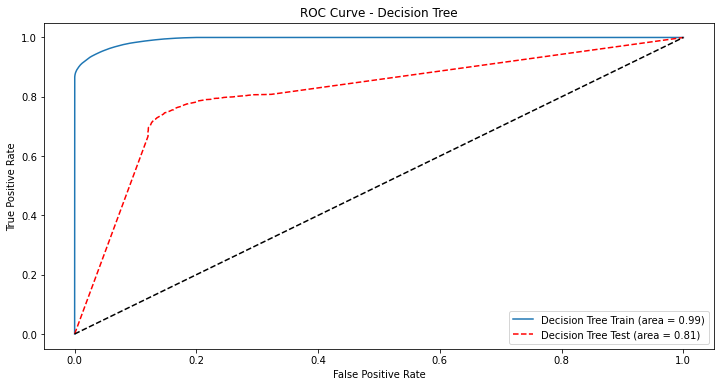

In [58]:
# Initialize the Decision Tree model
decision_tree = DecisionTreeClassifier()

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Predict probabilities on the training and test set
y_pred_prob_tree_train = decision_tree.predict_proba(X_train)[:, 1]  # Training probabilities
y_pred_prob_tree_test = decision_tree.predict_proba(X_test)[:, 1]  # Test probabilities

# Compute ROC curve and AUC for training data
fpr_tree_train, tpr_tree_train, _ = roc_curve(y_train, y_pred_prob_tree_train)
auc_tree_train = auc(fpr_tree_train, tpr_tree_train)

# Compute ROC curve and AUC for test data
fpr_tree_test, tpr_tree_test, _ = roc_curve(y_test, y_pred_prob_tree_test)
auc_tree_test = auc(fpr_tree_test, tpr_tree_test)

# Plotting ROC Curves
plt.figure(figsize=(12, 6))
plt.plot(fpr_tree_train, tpr_tree_train, label='Decision Tree Train (area = {:.2f})'.format(auc_tree_train))
plt.plot(fpr_tree_test, tpr_tree_test, color='red', linestyle='--', label='Decision Tree Test (area = {:.2f})'.format(auc_tree_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

## 6.4 Hyper tuning

We performed hyperparameter tuning with the Decision Tree classifier and Logistic Regression in the notebook: 02_model_creation.ipynb. We identified the parameters that yielded the best results. For a detailed step-by-step guide, please refer to [Go to Notebook 02_model_creation.ipynb](02_model_creation.ipynb)

The code below uses the best parameters to compute the Decision Tree classifier.

In [59]:
# Define the best parameters obtained from grid search
best_params = {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 5}

# Initialize the Decision Tree model with best parameters
decision_tree = DecisionTreeClassifier(**best_params)

# Fit the model on the training data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=8, min_samples_split=5)

Let's do the curve ROC and see the values AUC with the values for this Decision TreeClassifier 

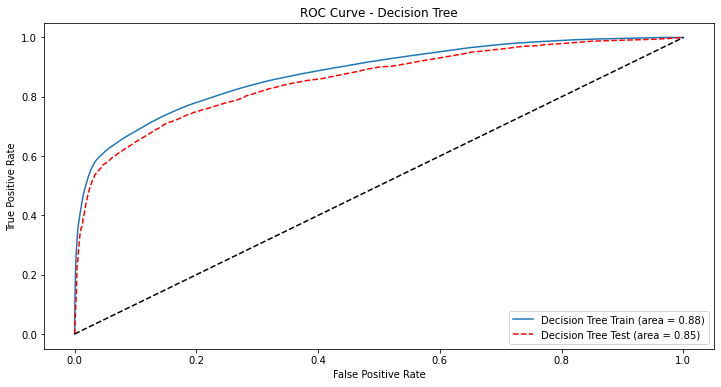

In [60]:
# # Predict probabilities on the training and test set
y_pred_prob_tree_train = decision_tree.predict_proba(X_train)[:, 1]  # Training probabilities
y_pred_prob_tree_test = decision_tree.predict_proba(X_test)[:, 1]  # Test probabilities


# Compute ROC curve and AUC for training data
fpr_tree_train, tpr_tree_train, _ = roc_curve(y_train, y_pred_prob_tree_train)
auc_tree_train = auc(fpr_tree_train, tpr_tree_train)

# Compute ROC curve and AUC for test data
fpr_tree_test, tpr_tree_test, _ = roc_curve(y_test, y_pred_prob_tree_test)
auc_tree_test = auc(fpr_tree_test, tpr_tree_test)

# Plotting ROC Curves
plt.figure(figsize=(12, 6))
plt.plot(fpr_tree_train, tpr_tree_train, label='Decision Tree Train (area = {:.2f})'.format(auc_tree_train))
plt.plot(fpr_tree_test, tpr_tree_test, color='red', linestyle='--', label='Decision Tree Test (area = {:.2f})'.format(auc_tree_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

## 6.5 Confusion matrix

In [61]:
# Let's apply a threshold to the probabilities of y_pred_prob_log_reg_test to determine y_pred
y_pred_tree = np.where(y_pred_prob_tree_test >= 0.5, 1, 0)

# Confusion Matrix for Decision Tree
cm_tree = confusion_matrix(y_test, y_pred_tree)

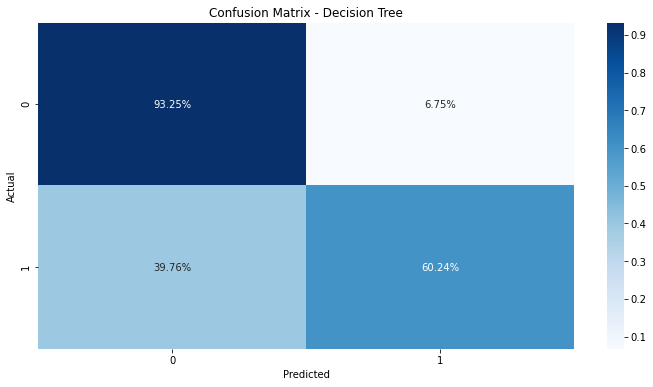

In [62]:
# Normalize the confusion matrix by row (actual class)
cm_tree_normalized = cm_tree.astype('float') / cm_tree.sum(axis=1)[:, np.newaxis]

# Plotting the Confusion Matrix for Decision Tree
plt.figure(figsize=(12, 6))
sns.heatmap(cm_tree_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

False Negatives (FN): 39.76%

- Impact: A high rate of false negatives means that a significant proportion of the positive class (e.g., non-functional pumps) is being misclassified as negative (e.g., functional pumps). This could lead to serious issues in the business context, as non-functional pumps that are not identified will not receive the necessary maintenance or repairs, leading to prolonged downtimes and possibly affecting the service quality and user satisfaction.
- Business Problem Impact: This could result in increased downtime for the pumps, higher maintenance costs over time, and a negative impact on customer satisfaction due to unreliable water supply.

False Positives (FP): 6.72%

- Impact: A relatively low rate of false positives indicates that only a small proportion of the negative class (e.g., functional pumps) is being misclassified as positive (e.g., non-functional pumps). While this is less severe compared to false negatives, it still leads to unnecessary maintenance actions being taken on functional pumps.
- Business Problem Impact: This could lead to inefficient allocation of resources, where time and effort are spent on checking or repairing pumps that are actually functional. This can increase operational costs and divert attention from genuinely non-functional pumps that need repairs.

# 6.6 Feature importance

We are now going to execute a feature importance code to be able to see the level of importance of all variables when doing the predictions

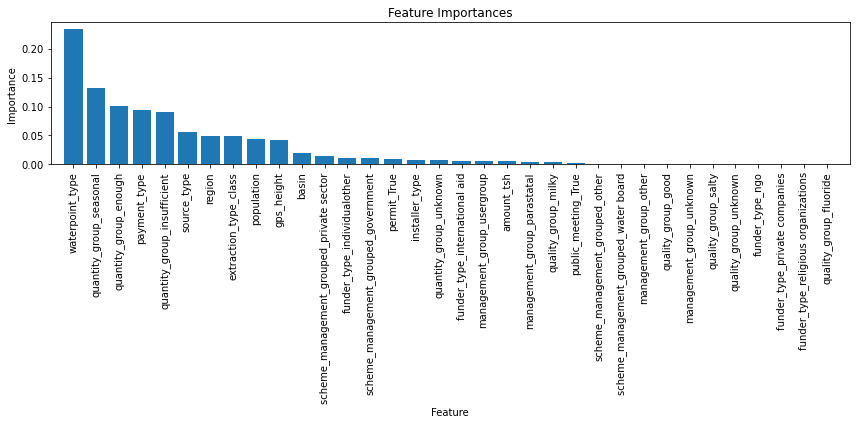

In [63]:
# Obtain the most important features affecting the status of a pump
importances = decision_tree.feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns

# Create a bar graph for the importance of the characteristics 
indexes = np.argsort(importances)[::-1]  # Order importances in descending order

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indexes], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indexes], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 7. PREDICTIONS

In this section, we will apply all the data transformations that were performed in the previous sections to the test dataset. Additionally, we will generate predictions for the test dataset using the best decision tree classifier model trained in the preceding section. To see the steps followed in detail, please click on this link [Go to Notebook 03_predict.ipynb](03_predict.ipynb).

With these steps, we aim to obtain predicted values and determine whether a pump will be functional or non-functional.

## 7.1 Define global variables

In [64]:
INPUT_PATH_Test_set_values = "../Data/Test_set_values.csv"

## 7.2 Import the dataset

In [65]:
df_predict = pd.read_csv(INPUT_PATH_Test_set_values)
df_predict.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


## 7.3 Apply the same data transformations on df_predict as the ones done in the data understanding section

## 7.3.1 Applying transformation functions

**Column 'funder'**

In [66]:
# Handling NaN values with a filler string like 'Unknown'
df_predict['funder'] = df_predict['funder'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'funder' column
df_predict['funder_type'] = df_predict['funder'].apply(categorize_funder)

# Check the categorized data
print(df_predict['funder_type'].value_counts())

Individual/Other           9955
Government                 2438
International Aid          2093
Religious Organizations     329
NGO                          29
Private Companies             6
Name: funder_type, dtype: int64


**Column 'installer'**

In [67]:
# Handling NaN values with a filler string like 'Unknown'
df_predict['installer'] = df_predict['installer'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'installer' column
df_predict['installer_type'] = df_predict['installer'].apply(categorize_installer)

# Now you can check your categorized data
print(df_predict['installer_type'].value_counts())

Other              8480
DWE                4537
Government          926
Community           599
Institutional       185
NGO                  93
Private Company      30
Name: installer_type, dtype: int64


**Column 'scheme_management_grouped'**

In [68]:
# Apply the grouping function to the 'scheme_management' column
df_predict['scheme_management_grouped'] = df_predict['scheme_management'].apply(group_scheme_management)

# Check the new value counts to see the grouped data
print(df_predict['scheme_management_grouped'].value_counts(normalize=True))

Government        0.699663
Community         0.131852
Other             0.083838
Water Board       0.048081
Private Sector    0.036566
Name: scheme_management_grouped, dtype: float64


## 7.3.2 Converting data types

In [69]:
# Converting 'construction_year' to object
df_predict['construction_year'] = df_predict['construction_year'].astype('object')

In [70]:
df_predict.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

## 7.3.3 Drop unnecesary columns

In [71]:
drop_column_list = ['scheme_name', 'num_private', 'wpt_name', 'subvillage', 'lga', 'ward', 'recorded_by','extraction_type_group',
                    'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'source_class',
                    'waterpoint_type_group', 'date_recorded','funder','installer','scheme_management',
                    'longitude','latitude','region_code','district_code','construction_year']

In [72]:
df_predict = df_predict.drop(drop_column_list, axis=1)

## 7.3.4 Cleaning the data set

In [73]:
# Apply the cleaning function to each object-type column in the DataFrame
for col in df_predict.select_dtypes(include='object').columns:
    df_predict[col] = df_predict[col].apply(clean_text)

## 7.3.5 Fillna with the modes calculated in the data preprocessing section

In [74]:
(df_predict.isna().sum()/len(df_predict))*100

id                           0.000000
amount_tsh                   0.000000
gps_height                   0.000000
basin                        0.000000
region                       0.000000
population                   0.000000
public_meeting               5.528620
permit                       4.962963
extraction_type_class        0.000000
management_group             0.000000
payment_type                 0.000000
quality_group                0.000000
quantity_group               0.000000
source_type                  0.000000
waterpoint_type              0.000000
funder_type                  0.000000
installer_type               0.000000
scheme_management_grouped    0.000000
dtype: float64

From the python script 01_data_preprocessing we know that public_meeting_mode is 1.0 and the permit_mode is 1.0. So we are going to directly fill the NaNs of public_meeting and of permit with the value 1.0

**Fillna in column 'public_meeting'**

In [75]:
df_predict['public_meeting'].fillna(1.0, inplace=True)

**Fillna in column 'permit'**

In [76]:
df_predict['permit'].fillna(1.0, inplace=True)

Let's check that there are no more null-values left

In [77]:
(df_predict.isna().sum()/len(df_predict))*100

id                           0.0
amount_tsh                   0.0
gps_height                   0.0
basin                        0.0
region                       0.0
population                   0.0
public_meeting               0.0
permit                       0.0
extraction_type_class        0.0
management_group             0.0
payment_type                 0.0
quality_group                0.0
quantity_group               0.0
source_type                  0.0
waterpoint_type              0.0
funder_type                  0.0
installer_type               0.0
scheme_management_grouped    0.0
dtype: float64

## 7.3.6 Doing target enconder on the categorical columns

Let's apply a one hot encoder for the categorical columns that have 6 or less categories

In [78]:
# Capture categorical columns from X_train for encoding
categorical_columns = df_predict.select_dtypes(include=['object', 'category']).columns


# Encoding the categorical columns in df_predict
for col in categorical_columns:
    if df_predict[col].nunique() <= 6:
        # Apply OneHotEncoder for columns with 6 or fewer unique values
        df_predict = pd.get_dummies(df_predict, columns=[col], drop_first=True)

Let's call in the saved fits (for the categorical columns that have more than 6 categories) applied to the categorical columns in the 01_data_preprocessing script

In [79]:
df_predict.columns

Index(['id', 'amount_tsh', 'gps_height', 'basin', 'region', 'population',
       'extraction_type_class', 'payment_type', 'source_type',
       'waterpoint_type', 'installer_type', 'public_meeting_True',
       'permit_True', 'management_group_other', 'management_group_parastatal',
       'management_group_unknown', 'management_group_usergroup',
       'quality_group_fluoride', 'quality_group_good', 'quality_group_milky',
       'quality_group_salty', 'quality_group_unknown', 'quantity_group_enough',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'quantity_group_unknown', 'funder_type_individualother',
       'funder_type_international aid', 'funder_type_ngo',
       'funder_type_private companies', 'funder_type_religious organizations',
       'scheme_management_grouped_government',
       'scheme_management_grouped_other',
       'scheme_management_grouped_private sector',
       'scheme_management_grouped_water board'],
      dtype='object')

In [80]:
# Column 'basin'
basin_pickle = pickle.load(open('model_objects/basin_target_encoder.pickle', 'rb'))
df_predict['basin'] = basin_pickle.transform(df_predict['basin'])

# Column 'extraction_type_class'
extraction_type_class_pickle = pickle.load(open('model_objects/extraction_type_class_target_encoder.pickle', 'rb'))
df_predict['extraction_type_class'] = extraction_type_class_pickle.transform(df_predict['extraction_type_class'])

# Column 'installer_type'
installer_type_pickle = pickle.load(open('model_objects/installer_type_target_encoder.pickle', 'rb'))
df_predict['installer_type'] = installer_type_pickle.transform(df_predict['installer_type'])

# Column 'payment_type'
payment_type_pickle = pickle.load(open('model_objects/payment_type_target_encoder.pickle', 'rb'))
df_predict['payment_type'] = payment_type_pickle.transform(df_predict['payment_type'])

# Column 'region_target'
region_target_pickle = pickle.load(open('model_objects/region_target_encoder.pickle', 'rb'))
df_predict['region'] = region_target_pickle.transform(df_predict['region'])

# Column 'source_type'
source_type_pickle = pickle.load(open('model_objects/source_type_target_encoder.pickle', 'rb'))
df_predict['source_type'] = source_type_pickle.transform(df_predict['source_type'])

# Column 'waterpoint_type'
waterpoint_type_pickle = pickle.load(open('model_objects/waterpoint_type_target_encoder.pickle', 'rb'))
df_predict['waterpoint_type'] = waterpoint_type_pickle.transform(df_predict['waterpoint_type'])

## 7.3.7 Dealing with numerical columns

Let's call in the saved fits applied to the numerical columns in the 01_data_preprocessing script

In [81]:
# Capture numerical columns
numerical_columns = df_predict.select_dtypes(include=['int64', 'float64']).columns

# Let's also drop column 'id' from the numerical_columns as they don't serve for the modeling
numerical_columns = numerical_columns.drop('id')

# Numerical Columns
numerical_columns_pickle = pickle.load(open('model_objects/numerical_columns_scaler.pickle', 'rb'))
df_predict[numerical_columns] = numerical_columns_pickle.transform(df_predict[numerical_columns])

## 7.3.8 Apply the Decision Tree Classifier created in the model creation section

In [82]:
df_predict

,id,amount_tsh,gps_height,basin,region,population,extraction_type_class,payment_type,source_type,waterpoint_type,...,quantity_group_unknown,funder_type_individualother,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board
0,50785,-0.100621,1.915327,-0.379005,-0.984626,2979.061988,2.617222,0.771866,-1.683683,2.622191,...,0,1,0,0,0,0,1,0,0,0
1,51630,-0.100621,1.299135,-0.379010,-1.835764,2783.936606,-0.521411,0.771866,-1.112570,-0.510890,...,0,0,0,0,0,0,1,0,0,0
2,17168,-0.100621,1.296248,-0.379005,1.032355,4642.273578,2.617222,0.771866,-1.683683,2.622191,...,0,0,1,0,0,0,1,0,0,0
3,45559,-0.100621,-0.579749,-0.378561,3.744407,2319.352363,2.617222,1.090170,0.850673,2.622191,...,0,1,0,0,0,0,1,0,0,0
4,49871,0.055600,0.853225,-0.378561,-0.024106,553.932240,-0.521411,-1.330306,-1.112570,-0.510890,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,-0.100621,-0.915985,-0.378824,0.161577,182.264846,1.165688,0.771866,-0.540840,-0.510890,...,0,1,0,0,0,0,1,0,0,0
14846,18990,0.211821,-0.965049,-0.379010,0.365118,27499.818332,-0.463637,-1.717105,0.850673,-0.359301,...,0,1,0,0,0,0,1,0,0,0
14847,28749,-0.100621,1.164929,-0.379005,1.032355,1854.768120,-0.521411,0.771866,2.604791,-0.510890,...,0,0,1,0,0,0,1,0,0,0
14848,33492,-0.100621,0.475139,-0.379106,-0.024106,1390.183877,-0.521411,0.771866,-0.540840,-0.510890,...,0,1,0,0,0,0,1,0,0,0


In [83]:
df_predict_copy = df_predict.drop('id', axis=1)
df_predict_copy

,amount_tsh,gps_height,basin,region,population,extraction_type_class,payment_type,source_type,waterpoint_type,installer_type,...,quantity_group_unknown,funder_type_individualother,funder_type_international aid,funder_type_ngo,funder_type_private companies,funder_type_religious organizations,scheme_management_grouped_government,scheme_management_grouped_other,scheme_management_grouped_private sector,scheme_management_grouped_water board
0,-0.100621,1.915327,-0.379005,-0.984626,2979.061988,2.617222,0.771866,-1.683683,2.622191,-0.005208,...,0,1,0,0,0,0,1,0,0,0
1,-0.100621,1.299135,-0.379010,-1.835764,2783.936606,-0.521411,0.771866,-1.112570,-0.510890,-0.281827,...,0,0,0,0,0,0,1,0,0,0
2,-0.100621,1.296248,-0.379005,1.032355,4642.273578,2.617222,0.771866,-1.683683,2.622191,-0.005208,...,0,0,1,0,0,0,1,0,0,0
3,-0.100621,-0.579749,-0.378561,3.744407,2319.352363,2.617222,1.090170,0.850673,2.622191,-0.005208,...,0,1,0,0,0,0,1,0,0,0
4,0.055600,0.853225,-0.378561,-0.024106,553.932240,-0.521411,-1.330306,-1.112570,-0.510890,-0.005208,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,-0.100621,-0.915985,-0.378824,0.161577,182.264846,1.165688,0.771866,-0.540840,-0.510890,-0.005208,...,0,1,0,0,0,0,1,0,0,0
14846,0.211821,-0.965049,-0.379010,0.365118,27499.818332,-0.463637,-1.717105,0.850673,-0.359301,-0.005208,...,0,1,0,0,0,0,1,0,0,0
14847,-0.100621,1.164929,-0.379005,1.032355,1854.768120,-0.521411,0.771866,2.604791,-0.510890,-0.005208,...,0,0,1,0,0,0,1,0,0,0
14848,-0.100621,0.475139,-0.379106,-0.024106,1390.183877,-0.521411,0.771866,-0.540840,-0.510890,-0.281827,...,0,1,0,0,0,0,1,0,0,0


In [84]:
# Decision Tree Classifier
df_predict['status_group'] = decision_tree.predict_proba(df_predict_copy)[:, 1]

In [85]:
# Apply a threshold to the probabilities of status_group to determine to which status group each id belongs to
df_predict['status_group_class'] = df_predict['status_group'].map(lambda x: 'Non-functional' if x>=0.5 else 'Functional')

In [86]:
df_predict[['id','status_group', 'status_group_class']]

,id,status_group,status_group_class
0,50785,0.884615,Non-functional
1,51630,0.163102,Functional
2,17168,0.666667,Non-functional
3,45559,0.988601,Non-functional
4,49871,0.576923,Non-functional
...,...,...,...
14845,39307,0.816399,Non-functional
14846,18990,0.154597,Functional
14847,28749,0.255814,Functional
14848,33492,0.255814,Functional


# 8. Conclusion

Considering the distribution of the dependent variable

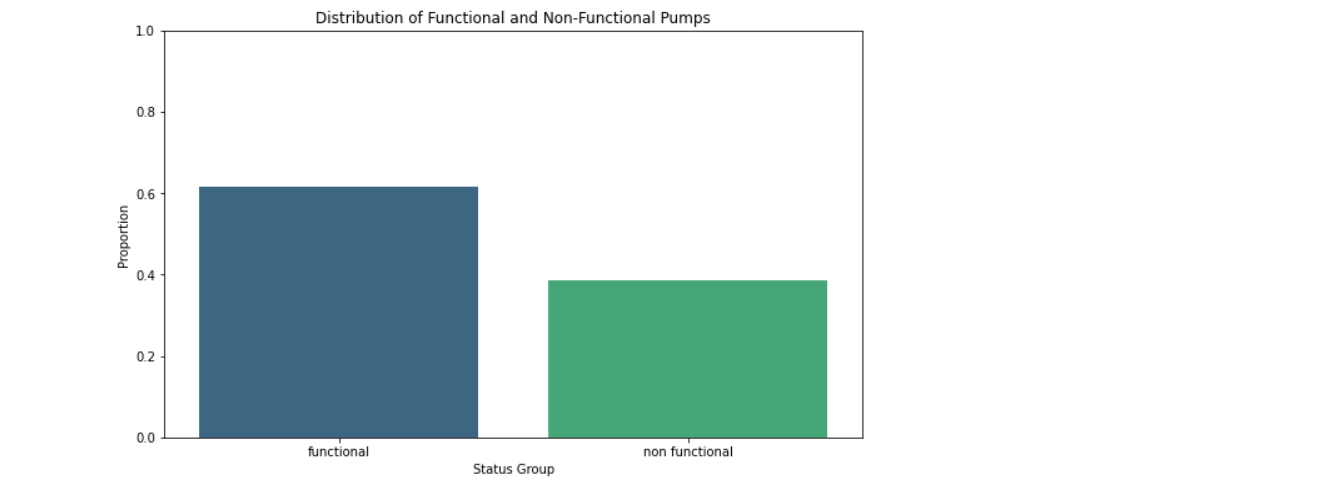

As we can see there is not an imbalance problem even though the majority of pumps are functional. 

Diving into the model results, let's begin by looking into the confusion matrix

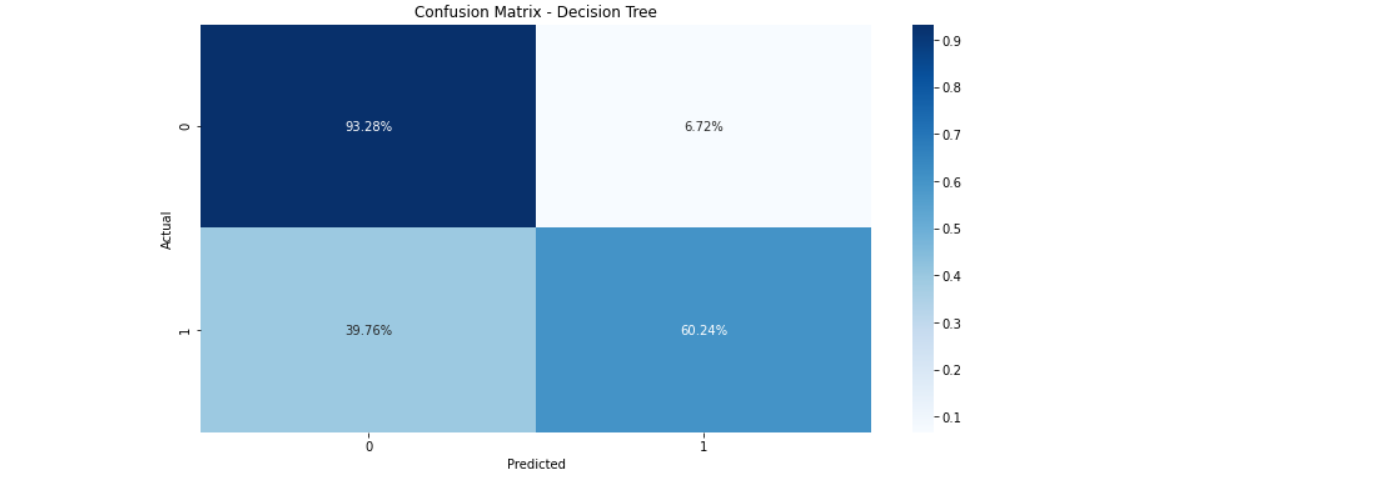

The confusion matrix indicates that the model has a high rate of false negatives (39.76%), which can significantly impact the business by failing to identify non-functional pumps that need repairs. This can lead to prolonged downtimes and negatively affect customer satisfaction. The false positive rate (6.72%) is relatively low, meaning fewer resources will be wasted on unnecessary maintenance. However, the primary concern should be reducing the false negative rate to ensure that non-functional pumps are correctly identified and repaired promptly.

Based on the metrics, the best AUC and confusion matrix is obtained with a Decision Tree Classifier. As is observable, the AUC is of 0.85 for the test. In the case of the Logistic Regression model, an AUC of 0.82 is obtained for the test.  

The variables that are most important and that permit us to best descriminate are:
1. waterpoint_type
2. quantity_group_seasonal
3. quantity_group_enough
4. payment_type
5. quantity_group_insufficient

We are interested in these 5 variables because they are the ones that have the most influence when determining whether a pump is functional or non-functional. 

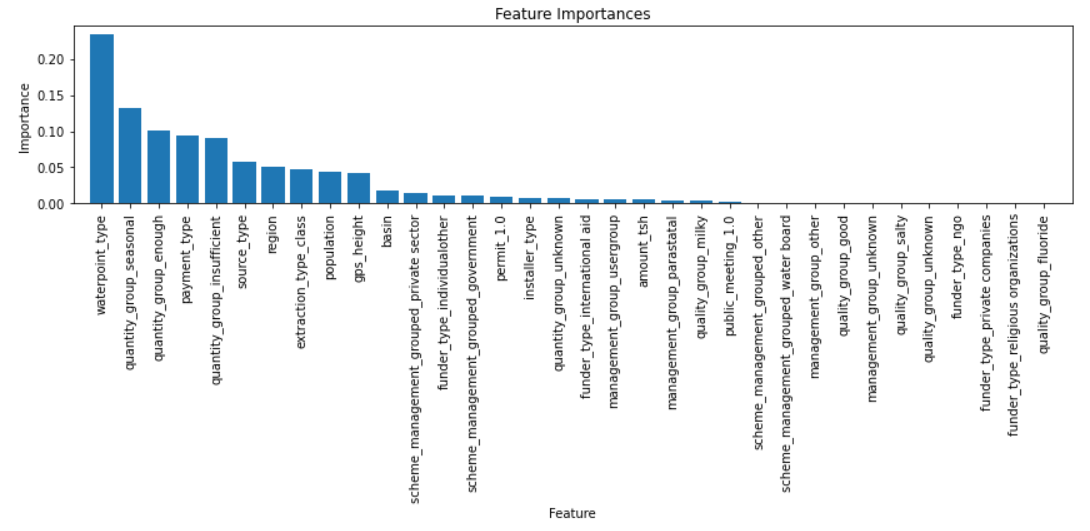

Considering that we used a one-hot encoder and that the categories for each variable were treated as independent variables, the three variables that contribute the most to the model are:

1. waterpoint_type
2. quantity_group
3. payment_type

Here we will show the contingency tables for each variable divided into functional, functional with repairs, and non functional pumps:

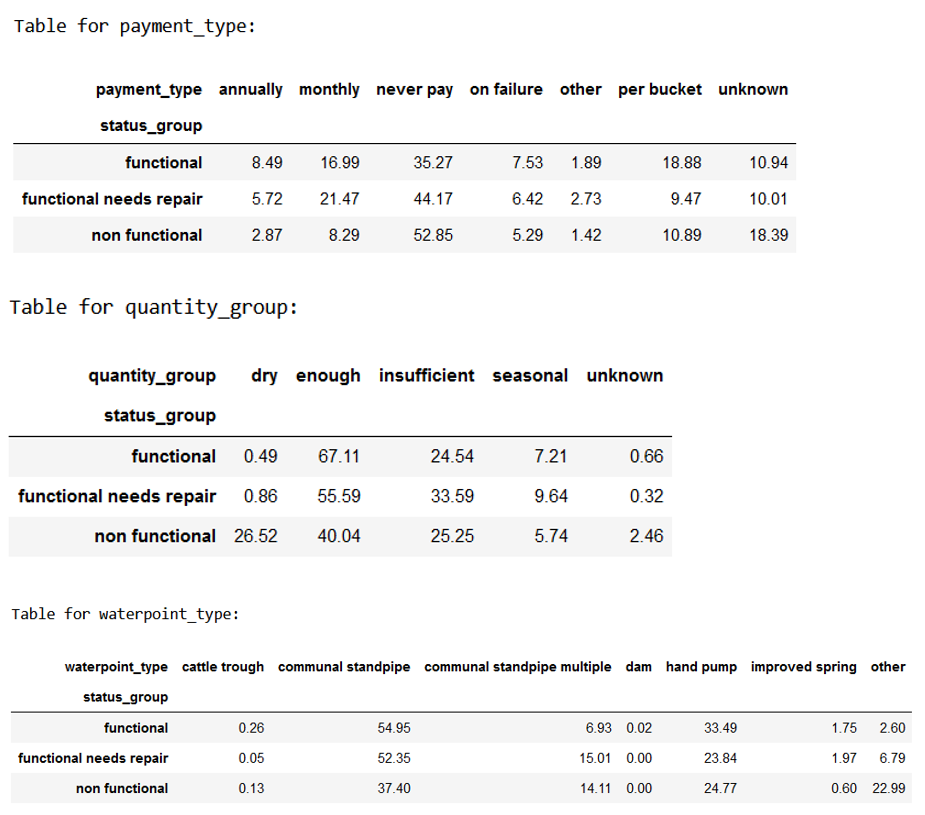


# 9. Recommendations

1. Considering that most of the functional pumps have monthly payment plans or a per bucket, the Tanzanian government can consider modifying the existing payment plans of those pumps where the payments are different from those payment types, so that the chance of the pump being functional can be increased.

2. Considering that almost none of the functional pumps are dry, it is possible to verify which pumps are dry as a proxy variable to know if they are functional or not and thus focus efforts on repairing them.

3. Considering that non-functional pumps have in most cases a waterpoint_type different from cattle trough, communal standpipe, communal standpipe multiple, dam, hand pump and improved spring, it is possible to verify which pumps do not have these waterpoint_types as a proxy variable to know if they are functional or not and thus focus efforts on repairing them.